Import threeML and tell the IPython notebook that we want plots to be shown inline:

In [5]:
from threeML import *

%matplotlib inline

Configuration read from /usr/threeML/config/threeML_config.yml



Get a list of available plugins:

In [2]:
getAvailablePlugins()

Plugins:

* SwiftXRTLike for Swift XRT                                   available
* FermiLATLike for Fermi LAT (standard classes)                available
* GenericOGIPLike for All OGIP-compliant instruments           available
* FermiGBMLike for Fermi GBM (all detectors)                   available


<h1>Load LAT data</h1>

Here we load LAT data using the LAT plugin for Unbinned Likelihood analysis, which uses the Fermi Science Tools under the hood. The files used here have been produced with the ST following the LAT data analysis described on the FSSC website.

A plugin based on software such as FermiPy could allow in the future to run a LAT analysis from scratch directly from 3ML.

In [6]:
lat_dir = os.path.join( os.getcwd(),'LAT')

eventfile = os.path.join(lat_dir,'gll_ft1_tr_bn090510016_v00_filt.fit')#event list
ft2file = os.path.join(lat_dir,'gll_ft2_tr_bn090510016_v00.fit')#spacecraft history
livetimeCube = os.path.join(lat_dir,'gll_ft1_tr_bn090510016_v00_filt_ltcube.fit')#livetime
kind = 'unbinned'
expomap = os.path.join(lat_dir,'gll_ft1_tr_bn090510016_v00_filt_expomap.fit')#exposure map

lat = FermiLATLike("LAT",eventfile,ft2file,livetimeCube,kind,expomap,'CALDB')#CALDB means automated response function discovery

<h1>Load Swift/XRT data</h1>

Here we load Swift/XRT data, reduced the Swift official software.

In [7]:
xrt_dir = os.path.join( os.getcwd(),'xrt')

source = os.path.join(xrt_dir,'jointwtsource.pi')#spectrum in source region
bkg = os.path.join(xrt_dir,'jointwtback.pi')#background spectrum
rmf = os.path.join(xrt_dir,'jointwt.rmf')#redistribution matrix = energy dispersion
arf = os.path.join(xrt_dir,'jointwt.arf')#ancillary response = effective area

xrt = SwiftXRTLike('XRT',source,bkg,rmf,arf)

#Here we select to use the energy from 1 keV to 10 keV.

#We use 1.0 keV as start energy because we didn't implement yet
#absorption models in 3ML, hence we need to exclude the energy
#range where interstellar absorption is important

xrt.setActiveMeasurements("1.0-10.0")

Now using 901 channels out of 1024


<h1>Define the Likelihood model</h1>

Let's start by defining a point source with a power-law spectrum at the position of the GRB.

In [51]:
powerlaw = PowerLaw()

#You can print the model by doing this
print(powerlaw)

Spectral model: Powerlaw
Formula:



<IPython.core.display.Latex object>


Current parameters:



Name Value Minimum    Maximum    Delta Status Unit      Prior     
----- ----- ------- ------------- ----- ------ ---- ---------------
gamma  -2.0   -10.0          10.0   0.1   free         UniformPrior
 logA  -4.0   -40.0          30.0   0.1   free      LogUniformPrior
 Epiv   1.0   1e-10 10000000000.0   1.0  fixed  keV    UniformPrior

You can modify the parameters like this:

In [52]:
#init value
powerlaw.gamma.value = -2.3

#Boundaries
powerlaw.gamma.setBounds( -5, +5 )

#Initial delta for Minuit
powerlaw.gamma.setDelta( 0.08 )

#Fix it for a second
powerlaw.gamma.fix()

#set it free again
powerlaw.gamma.free()

#check our changes

print(powerlaw)

Spectral model: Powerlaw
Formula:



<IPython.core.display.Latex object>


Current parameters:



Name Value Minimum    Maximum    Delta Status Unit      Prior     
----- ----- ------- ------------- ----- ------ ---- ---------------
gamma  -2.3    -5.0           5.0  0.08   free         UniformPrior
 logA  -4.0   -40.0          30.0   0.1   free      LogUniformPrior
 Epiv   1.0   1e-10 10000000000.0   1.0  fixed  keV    UniformPrior

Now define the point source model:

In [74]:
ra = 333.6
dec = -26.6

pts1 = PointSource("GRB090510", ra, dec, powerlaw)

#We can print also the PointSource model

print(pts1)


Spatial model: Point source
Formula:



<IPython.core.display.Latex object>


Spectral model: Powerlaw

Current parameters:



Name     Value      Minimum    Maximum         Delta      Status Unit
----- -------------- ------- ------------- --------------- ------ ----
   RA          333.6     0.0         360.0            0.01  fixed  deg
  Dec          -26.6   -90.0          90.0            0.01  fixed  deg
gamma -1.74813472292    -5.0           5.0 0.0501357458739   free     
 logA -1.49542592938   -40.0          30.0 0.0123703122257   free     
 Epiv            1.0   1e-10 10000000000.0             1.0  fixed  keV

Now define the likelihood model. In this case it contains only the GRB. Note that the background for each instrument is handled separately under the hood by the relative plugin.

In [75]:
model = LikelihoodModel(pts1)

#We didn't implement yet a meaningful print functionality

<h1>Perform likelihood fit</h1>

First we need to define the data we want to use. In this case, LAT and XRT:

In [55]:
data = DataList(lat, xrt)

Now define a joint likelihood analysis and run the fit.

In [76]:
jl = JointLikelihood(model,data)


Found Isotropic template for irf P8R2_TRANSIENT020E_V6: /software/src/FermiScienceTools/GLAST_EXT/diffuseModels/v2r0/iso_P8R2_TRANSIENT020E_V6_v06.txt

Found Galactic template for IRF. P8R2_TRANSIENT020E_V6: /software/src/FermiScienceTools/GLAST_EXT/diffuseModels/v2r0/gll_iem_v06.fits

Cutting the template around the ROI: 

Center is (1636.35366524,279.048128465) pixel, (24.6067081551,-55.1189839419) sky
Approximating the X pixel: 1636.35366524 -> 1636
Approximating the Y pixel: 279.048128465 -> 279
X range -> 1149 - 2124
Y range -> 40 - 519
Input image shape is ([z],y,x) = (30, 1441, 2880)


Note that the LAT plugin assumes the standard Galactic diffuse and isotropic background templates.

In [57]:
results = jl.fit()

Best fit values:



Name             Value       Unit
------------------ ---------------- ----
gamma_of_GRB090510 -1.747 +/- 0.028     
 logA_of_GRB090510 -1.495 +/- 0.021


NOTE: errors on parameters are approximate. Use getErrors().

Nuisance parameters:



Name                     Value     Unit
-------------------------------------- ------------ ----
         GalacticTemplate-Value_of_LAT          1.5     
IsotropicTemplate-Normalization_of_LAT 1.2268343317     
        GRB090510-Normalization_of_LAT          1.0     
                     InterCalib_of_XRT            1


Correlation matrix:



1.00 -0.50
-0.50  1.00


Minimum of -logLikelihood is: 780.665411273

Contributions to the -logLikelihood at the minimum:



Detector -LogL 
-------- ------
     LAT 115.20
     XRT 664.73

Get more accurate errors using Minos.

In [58]:
errors = jl.getErrors()

Name               Value         Unit
------------------ -------------------- ----
gamma_of_GRB090510 -1.748 -0.030 +0.027     
 logA_of_GRB090510 -1.495 -0.021 +0.021

<h1>Look at the results</h1>

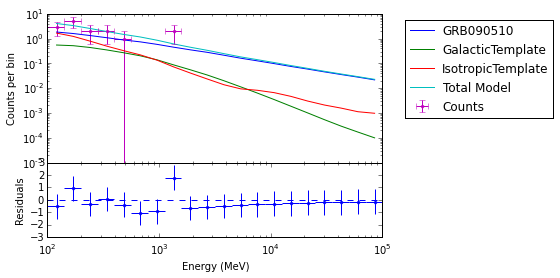

In [20]:
lat_fig = lat.display()

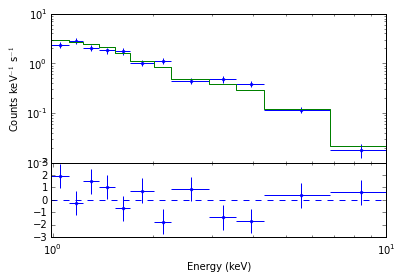

In [21]:
xrt_fig = xrt.display()

We can also look at the likelihood profile for single parameters:

 [*********************100%***********************]  40 of 40 completed in 5.2 s

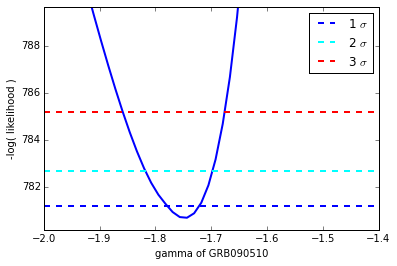

In [24]:
contours = jl.getContours('GRB090510','gamma',-2.0,-1.5,40)

Or, we can produce contour plots:

 [*********************100%***********************]  400 of 400 completed in 3.6 s

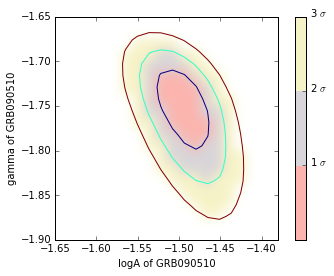

In [39]:
contours2 = jl.getContours('GRB090510','gamma',-1.9,-1.65,20,'GRB090510','logA',-1.65,-1.38,20)

<h1>Custom spectral model</h1>

Defining a spectral model is easy in 3ML:

In [59]:
mymodel_def = '''
mypowerlaw: A*power(e/1., gamma)
init: A=1e-2, gamma=-2.0
bounds: 1e-6 <= A <= 10, -5 <= gamma <= 5
'''

mymodel = CustomSpectralModel(mymodel_def)


You can also use an external function, so you can use anything you have available in python:

In [92]:
import numpy as np

#Define a power law with a positive index,
#just to see that it is actually working

def dumb_powerlaw(e, norm, index):
    
    Epiv = 1
    
    return norm * np.power(e / Epiv, -index)

mymodel_def = '''
mypowerlaw: dumb_powerlaw(e, A, gamma)
init: A=1e-2, gamma=2.0
bounds: 1e-6 <= A <= 10, -5 <= gamma <= 5
'''

#NOTE: you HAVE to provide the function with the 'function' option

mymodel = CustomSpectralModel(mymodel_def, function=dumb_powerlaw)

#Verify that it is actually working

ra = 333.6
dec = -26.6

pts1 = PointSource("GRB090510", ra, dec, mymodel)

model = LikelihoodModel(pts1)

data = DataList(lat, xrt)

jl = JointLikelihood(model, data)

res = jl.fit()


Found Isotropic template for irf P8R2_TRANSIENT020E_V6: /software/src/FermiScienceTools/GLAST_EXT/diffuseModels/v2r0/iso_P8R2_TRANSIENT020E_V6_v06.txt

Found Galactic template for IRF. P8R2_TRANSIENT020E_V6: /software/src/FermiScienceTools/GLAST_EXT/diffuseModels/v2r0/gll_iem_v06.fits

Cutting the template around the ROI: 

Center is (1636.35366524,279.048128465) pixel, (24.6067081551,-55.1189839419) sky
Approximating the X pixel: 1636.35366524 -> 1636
Approximating the Y pixel: 279.048128465 -> 279
X range -> 1149 - 2124
Y range -> 40 - 519
Input image shape is ([z],y,x) = (30, 1441, 2880)
Best fit values:



/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:10: RuntimeWarning: divide by zero encountered in power


Name            Value       Unit
-------------- ----------------- ----
A_of_GRB090510 0.0320 +/- 0.0016     
gamma_of_GRB09   1.749 +/- 0.028


NOTE: errors on parameters are approximate. Use getErrors().

Nuisance parameters:



Name                      Value     Unit
-------------------------------------- ------------- ----
         GalacticTemplate-Value_of_LAT           1.5     
IsotropicTemplate-Normalization_of_LAT 1.23578770337     
        GRB090510-Normalization_of_LAT           1.0     
                     InterCalib_of_XRT             1


Correlation matrix:



1.00 0.50
0.50 1.00


Minimum of -logLikelihood is: 780.665269961

Contributions to the -logLikelihood at the minimum:



Detector -LogL 
-------- ------
     LAT 115.15
     XRT 664.77

In [93]:
errors = jl.getErrors()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:10: RuntimeWarning: divide by zero encountered in power


Name              Value          Unit
-------------- ---------------------- ----
A_of_GRB090510 0.0320 -0.0015 +0.0016     
gamma_of_GRB09    1.748 -0.027 +0.030

<h1>Bayesian sampling</h1>

3ML can be used also for Bayesian Analysis. At the moment, only a posterior sampling with emcee is implemented.

First import the module and define the bayesian analysis.

In [100]:
from threeML.bayesian.bayesianAnalysis import *

from threeML.bayesian.Priors import *

#The priors are uniform priors for normal parameters,
#and log-uniform for normalization parameters. This default
#can of course be changed like:
#mymodel.A.prior = GaussianPrior(mu,sigma)
#or
#mymodel.A.prior = UniformPrior(min,max)

#Here we explicitly set the prior for A, since
#3ML does not have any way to know for user-defined
#models which parameters are normalizations
mymodel.A.prior = LogUniformPrior(1e-9,0.1)

bayes = bayesianAnalysis(model, data)


Found Isotropic template for irf P8R2_TRANSIENT020E_V6: /software/src/FermiScienceTools/GLAST_EXT/diffuseModels/v2r0/iso_P8R2_TRANSIENT020E_V6_v06.txt

Found Galactic template for IRF. P8R2_TRANSIENT020E_V6: /software/src/FermiScienceTools/GLAST_EXT/diffuseModels/v2r0/gll_iem_v06.fits

Cutting the template around the ROI: 

Center is (1636.35366524,279.048128465) pixel, (24.6067081551,-55.1189839419) sky
Approximating the X pixel: 1636.35366524 -> 1636
Approximating the Y pixel: 279.048128465 -> 279
X range -> 1149 - 2124
Y range -> 40 - 519
Input image shape is ([z],y,x) = (30, 1441, 2880)


Sample from the posterior with emcee:

In [103]:
nwalkers = 6 #number of random points used for likelihood integration
nsamples = 3000 #number of samples for the scan
burn_in = 100 #number of samples for initial exploratory scan

samples = bayes.sample(nwalkers, burn_in, nsamples)

Running burn-in of 100 samples...

 [*********************100%***********************]  100 of 100 completed in 2.9 s

Sampling...

 [*********************100%***********************]  3000 of 3000 completed in 82.5 s
Mean acceptance fraction: 0.721222222222


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:10: RuntimeWarning: divide by zero encountered in power


Display a corner (triangle) plot which shows the marginalized distributions as well as the correlations between parameters:

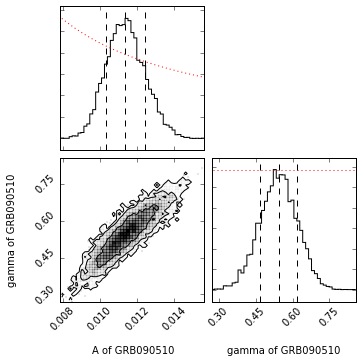

In [102]:
_ = bayes.cornerPlot(plot_contours=True)